#### 讀檔

In [1]:
import os
import pandas as pd

def load_all_stock_data(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            path = os.path.join(folder_path, filename)
            tic = filename.replace("converted_", "").replace(".csv", "")
            df = pd.read_csv(path)
            df['tic'] = tic  # 加上股票代碼欄位
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# 📂 資料夾路徑
folder_path = "E:\python_project\class\Reinforce_Learning\RL\code\converted_stock"

# 📈 載入所有股票資料
raw_df = load_all_stock_data(folder_path)

# # 🔍 查看資料概況
# print(raw_df.shape)
# print(raw_df[['date', 'tic']].drop_duplicates().head())


#### 補值

In [2]:
import pandas as pd
import numpy as np

def interpolate_stock_data(df, start_date="2020-01-01", end_date="2024-10-30"):
    # 建立完整日期範圍（僅工作日）
    full_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' 是 business day

    result_list = []

    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy()
        sub_df['date'] = pd.to_datetime(sub_df['date'])

        # 設定 index 為日期後 reindex
        sub_df = sub_df.set_index('date').reindex(full_dates)
        sub_df['tic'] = tic  # 保留股票代碼欄位
        sub_df.index.name = 'date'

        # 線性補值（針對數值欄位）
        num_cols = ['open', 'high', 'low', 'close', 'volume']
        for col in num_cols:
            if col in sub_df.columns:
                sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

        result_list.append(sub_df.reset_index())

    # 合併所有股票資料
    full_df = pd.concat(result_list, ignore_index=True)
    return full_df

# 📈 執行補值
interpolated_df = interpolate_stock_data(raw_df)

# 🔍 檢查結果
print(interpolated_df.shape)
print(interpolated_df.head())


(10088, 7)
        date       open       high        low      close     volume      tic
0 2020-01-01  82.237405  83.042405  82.237405  82.745827  4882015.0  0050.TW
1 2020-01-02  82.237405  83.042405  82.237405  82.745827  4882015.0  0050.TW
2 2020-01-03  83.296619  83.635563  82.195034  82.745827  6813547.0  0050.TW
3 2020-01-06  82.237408  82.279772  81.686615  81.686615  9321768.0  0050.TW
4 2020-01-07  81.728982  81.940825  80.839246  81.432404  6328602.0  0050.TW


C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Serie

#### DTW分群

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tslearn.metrics import cdist_dtw
from pyclustering.cluster.kmedoids import kmedoids
import matplotlib.pyplot as plt
import matplotlib.cm as cm

e:\python_project\class\class_env\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
def calculate_log_return(df):
    df['date'] = pd.to_datetime(df['date'])
    result = {}

    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy().set_index('date').sort_index()
        sub_df['log_return'] = np.log(sub_df['close'] / sub_df['close'].shift(1))
        result[tic] = sub_df['log_return'].dropna()

    return pd.DataFrame(result)


In [5]:
def calculate_log_return(df):
    df['date'] = pd.to_datetime(df['date'])
    result = {}

    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy().set_index('date').sort_index()
        sub_df['log_return'] = np.log(sub_df['close'] / sub_df['close'].shift(1))
        result[tic] = sub_df['log_return'].dropna()

    return pd.DataFrame(result)


In [6]:

def dtw_cluster(log_return_df, k=3):
    series_array = log_return_df.T.values[..., np.newaxis]
    dist_matrix = cdist_dtw(series_array)
    initial_medoids = list(range(k))

    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix', ccore=False)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()

    label_map = {}
    stock_list = list(log_return_df.columns)
    for i, cluster in enumerate(clusters):
        for idx in cluster:
            label_map[stock_list[idx]] = i
    return label_map


In [7]:
def plot_clusters(log_return_df, cluster_labels):
    grouped_stocks = {}
    for stock, group in cluster_labels.items():
        grouped_stocks.setdefault(group, []).append(stock)

    for group_id, stocks in grouped_stocks.items():
        plt.figure(figsize=(12, 4))
        for stock in stocks:
            plt.plot(log_return_df.index, log_return_df[stock], label=stock)
        plt.title(f"group {group_id}:no.{len(stocks)} ")
        plt.xlabel("date")
        plt.ylabel("normalization Log Return")
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
C:\Users\a9706\AppData\Local\Temp\ipykernel_66384\1499623503.py:23: FutureWarning: Serie

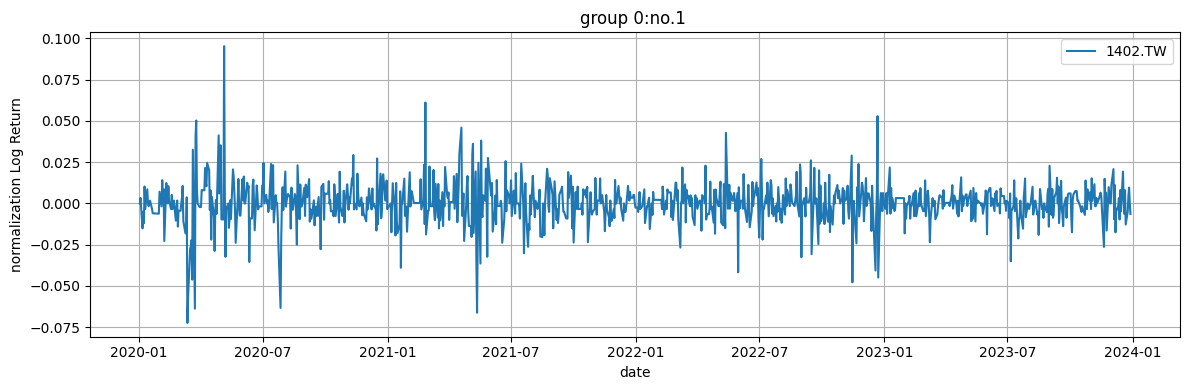

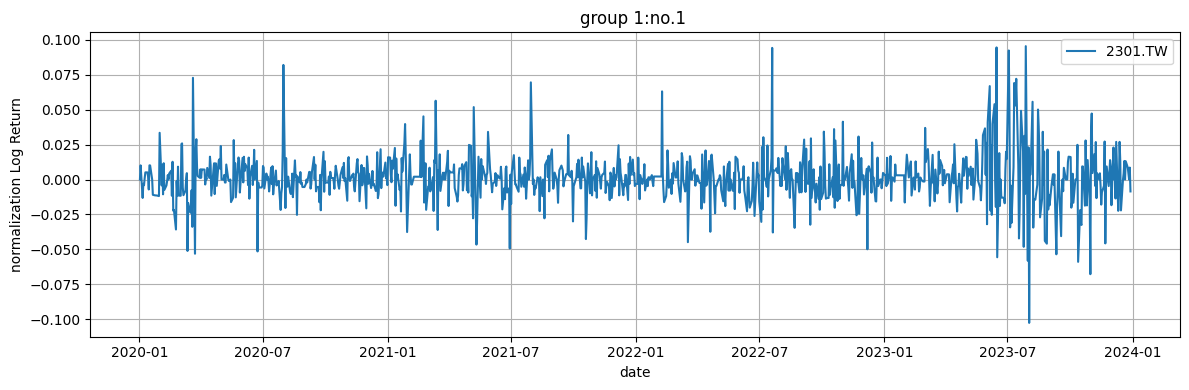

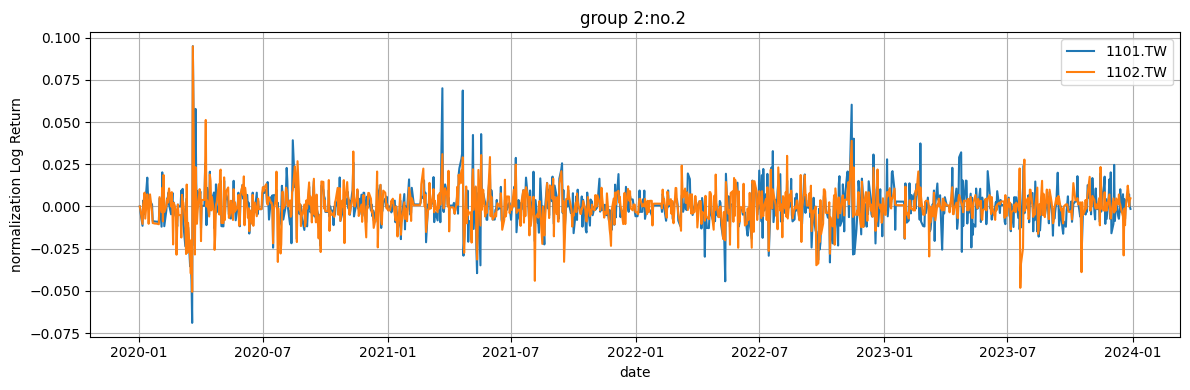

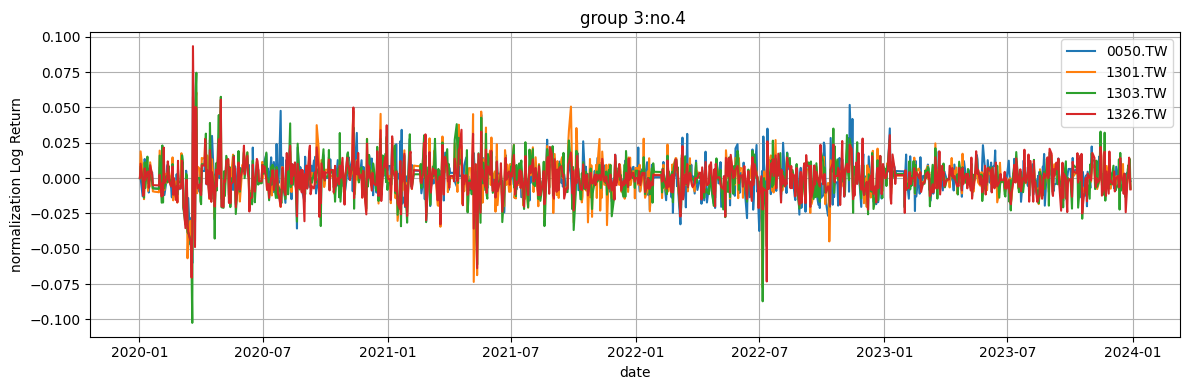

In [8]:
# 讀取資料夾中所有股票 CSV
def load_all_stock_data(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            path = os.path.join(folder_path, filename)
            tic = filename.replace("converted_", "").replace(".csv", "")
            df = pd.read_csv(path)
            df['tic'] = tic
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# 讀取 + 補值
folder_path = "E:\python_project\class\Reinforce_Learning\RL\code\converted_stock"
raw_df = load_all_stock_data(folder_path)
interpolated_df = interpolate_stock_data(raw_df)

# 計算 log return 並切割訓練集（只用到 2023-12-31）
log_return_df = calculate_log_return(interpolated_df)
train_log_return_df = log_return_df[log_return_df.index <= '2023-12-31']

# 正規化並分群
cluster_labels = dtw_cluster(train_log_return_df, k=4)

# 畫出分群結果
plot_clusters(train_log_return_df, cluster_labels)


### train model

In [9]:
import os
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import PPO
from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
import numpy as np

#### 訓練

##### 環境

In [10]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
from gym.utils import seeding
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv

class CustomStockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, config):
        super(CustomStockTradingEnv, self).__init__()

        # --- 原始數據和核心參數 ---
        # price_array: (天數, 股票數) - 每支股票每日的收盤價
        self.price_array = config['price_array']
        # tech_array: (天數, 股票數 * 指標數) - 每支股票每日的技術指標
        self.tech_array = config['tech_array']
        # volume_array: (天數, 股票數) - 每支股票每日的成交量 (新增)
        self.volume_array = config.get('volume_array', None) # 確保 config 傳入 volume_array
        # index_price_array: (天數,) - 大盤指數每日收盤價 (新增)
        self.index_price_array = config.get('index_price_array', None)

        self.initial_amount = config.get('initial_amount', 1e6)
        self.reward_scaling = config.get('reward_scaling', 1e-4)
        self.if_train = config.get('if_train', True) # 是否為訓練模式 (影響風控強制結束)
        self.max_stock = config.get('max_stock', 1e4) # 單一股票最大持股數量
        self.min_trade_unit = config.get('min_trade_unit', 1) # 最小交易單位 (股)

        # --- 台灣交易成本參數 (更精確) ---
        # 買入時：手續費 0.1425% (預設無折扣，或可依券商折扣調整)
        self.buy_brokerage_pct = config.get('buy_brokerage_pct', 0.001425)
        # 賣出時：手續費 0.1425% (預設無折扣) + 交易稅 0.3%
        self.sell_brokerage_pct = config.get('sell_brokerage_pct', 0.001425)
        self.transaction_tax_pct = config.get('transaction_tax_pct', 0.003)

        self.day = 0
        self.data_length, self.stock_dim = self.price_array.shape

        # --- 動作空間 ---
        # 動作空間：每個股票的交易比例，介於 -1 (全數賣出持有部位) 到 1 (用所有現金買入最大持股)
        # 這裡的 actions 代表的是基於當前 total_asset 的期望權重，再通過 softmax 歸一化
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.stock_dim,), dtype=np.float32)

        # --- 觀察空間 (更貼近現實) ---
        # 1 (現金) + stock_dim (持股數量) + stock_dim (當天股價) + tech_array.shape[1] (技術指標) + 1 (大盤指數)
        obs_dim = 1 + self.stock_dim + self.stock_dim + self.tech_array.shape[1]
        if self.index_price_array is not None:
            obs_dim += 1 # 如果有大盤指數，觀察空間多一個
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # --- 初始化環境狀態 ---
        self.reset()
        self.seed() # 初始化隨機種子

    def reset(self):
        self.day = 0
        self.amount = self.initial_amount # 當前現金
        self.stocks = np.zeros(self.stock_dim, dtype=np.float32) # 持有股票數量
        self.total_asset = self.amount # 總資產 (現金 + 股票市值)
        self.asset_memory = [self.total_asset] # 記錄每日總資產
        self.daily_return_memory = [0] # 記錄每日收益率
        self.actions_history = [np.zeros(self.stock_dim)] # 記錄每日操作，用於計算流動性
        self.peak_asset = self.initial_amount # 新增：記錄歷史最高總資產，用於計算回撤

        # 初始化大盤指數
        self.current_index_price = self.index_price_array[self.day] if self.index_price_array is not None else 0

        return self._get_observation()

    def step(self, actions):
        # 判斷是否到達數據末尾
        self.terminal = self.day >= self.data_length - 1
        if self.terminal:
            # 訓練結束時的績效輸出
            df_daily_return = pd.DataFrame(self.daily_return_memory)
            df_daily_return.columns = ['daily_return']
            if df_daily_return['daily_return'].std() != 0:
                sharpe = (252**0.5) * df_daily_return['daily_return'].mean() / df_daily_return['daily_return'].std()
            else:
                sharpe = 0
            print(f"=================================")
            print(f"訓練結束 (Day {self.day})")
            print(f"起始總資產: {self.asset_memory[0]:.2f}")
            print(f"最終總資產: {self.total_asset:.2f}")
            print(f"Sharpe Ratio: {sharpe:.4f}")
            print(f"=================================")

            return self._get_observation(), self.reward, self.terminal, {} # 使用 _get_observation() 確保最後一步的觀察空間正確

        # --- 獲取當日市場數據 ---
        begin_total_asset = self._calculate_total_asset()
        # 當前價格：收盤價
        prices = self.price_array[self.day]
        volumes = self.volume_array[self.day] if self.volume_array is not None else np.ones(self.stock_dim) * 1e9
        
        # --- 1. 台股漲跌幅限制 (±10%) 與流動性考量 ---
        effective_prices = np.copy(prices) # 當天實際交易價格，可能因漲跌停調整
        if self.day > 0:
            prev_prices = self.price_array[self.day - 1]
            # 計算漲停價和跌停價
            limit_up_prices = prev_prices * (1 + 0.10)
            limit_down_prices = prev_prices * (1 - 0.10)

            # 根據當日收盤價判斷是否觸及漲跌停
            hit_limit_up = (prices >= limit_up_prices - 1e-6) # 考慮浮點數誤差
            hit_limit_down = (prices <= limit_down_prices + 1e-6) # 考慮浮點數誤差

            # 調整 agent 的 actions 以符合漲跌停限制和流動性
            for i in range(self.stock_dim):
                # 如果股票漲停 (收盤價 = 漲停價): 禁止賣出 (agent 嘗試賣出則強制歸零)
                if hit_limit_up[i] and actions[i] < 0:
                    actions[i] = 0 # 漲停想賣，不執行
                # 如果股票跌停 (收盤價 = 跌停價): 禁止買入 (agent 嘗試買入則強制歸零)
                elif hit_limit_down[i] and actions[i] > 0:
                    actions[i] = 0 # 跌停想買，不執行
                
                # 更現實的考量：漲跌停時，成交量也趨近於零，這會影響可交易數量
                if hit_limit_up[i] or hit_limit_down[i]:
                     # 假設漲跌停時只能成交理論最大量的 5% (非常簡化，僅為示例)
                    actions[i] *= 0.05 # 大幅減少可交易量
                    
        # --- 將動作轉換為實際交易股數 ---
        # 根據新的動作範圍調整 desired_trades
        desired_trades = np.zeros(self.stock_dim, dtype=np.float32)
        for i in range(self.stock_dim):
            if actions[i] > 0.1: # 買入操作
                desired_trades[i] = actions[i] * self.max_stock
            elif actions[i] < -0.1: # 賣出操作
                desired_trades[i] = actions[i] * self.max_stock # 這裡仍使用 max_stock 進行比例縮放，後續會限制為持有數量

        # 記錄執行交易前的持股，用於計算實際交易量和成本
        prev_stocks = np.copy(self.stocks)
        
        # --- 2. 停損機制 (更現實的處理) ---
        if self.day > 0:
            prev_prices_for_stop_loss = self.price_array[self.day - 1]
            with np.errstate(divide='ignore', invalid='ignore'):
                price_change_for_stop_loss = (prices - prev_prices_for_stop_loss) / prev_prices_for_stop_loss
                price_change_for_stop_loss[np.isnan(price_change_for_stop_loss)] = 0
                price_change_for_stop_loss[np.isinf(price_change_for_stop_loss)] = 0

            for i in range(self.stock_dim):
                # 如果股票持有且價格下跌超過 10%
                if price_change_for_stop_loss[i] < -0.10 and self.stocks[i] > 0:
                    # 檢查是否觸及跌停板。如果觸及，則假設無法成交，停損失敗
                    if self.day > 0 and (prices[i] <= prev_prices_for_stop_loss[i] * (1 - 0.099)):
                        # print(f"Warning: Stop loss for stock {i} on day {self.day} triggered but hit limit down, cannot sell.")
                        continue # 跌停無法賣出，停損失敗
                    
                    # 否則，按當日收盤價強制賣出所有持股
                    traded_shares = self.stocks[i]
                    proceeds = traded_shares * prices[i] * (1 - self.sell_brokerage_pct - self.transaction_tax_pct)
                    self.amount += proceeds
                    self.stocks[i] = 0
                    # print(f"強制停損 {traded_shares} 股在 Day {self.day}, 股票 {i}")
                    desired_trades[i] = 0 # 停損後，agent 不再嘗試交易這支股票

        # --- 3. 執行買賣操作與計算交易成本 (更精確) ---
        actual_buy_value_before_fees = 0 # 記錄總買入金額（未含手續費）
        actual_sell_value_before_fees = 0 # 記錄總賣出金額（未含手續費和交易稅）
        
        # 執行賣出操作
        for i in range(self.stock_dim):
            if desired_trades[i] < -0.1: # 賣出操作
                trade_shares_raw = min(-desired_trades[i], self.stocks[i]) # 可賣出數量不能超過持有數量
                
                # 考慮成交量限制
                if self.volume_array is not None and volumes[i] > 0:
                    max_sell_by_volume = volumes[i] * 0.05 
                    trade_shares_raw = min(trade_shares_raw, max_sell_by_volume)
                
                # 四捨五入到最小交易單位 (向下取整，確保不會賣出過多)
                trade_shares = np.floor(trade_shares_raw / self.min_trade_unit) * self.min_trade_unit

                if trade_shares > 0:
                    proceeds = trade_shares * prices[i]
                    self.amount += proceeds * (1 - self.sell_brokerage_pct - self.transaction_tax_pct)
                    self.stocks[i] -= trade_shares
                    actual_sell_value_before_fees += proceeds # 記錄稅前收入

        # 執行買入操作
        for i in range(self.stock_dim):
            if desired_trades[i] > 0.1: # 買入操作
                cost_per_share_after_fees = prices[i] * (1 + self.buy_brokerage_pct)
                
                if cost_per_share_after_fees <= 0:
                    continue

                max_buyable_by_cash = self.amount // cost_per_share_after_fees
                max_buyable_by_holding = self.max_stock - self.stocks[i] # 總持股上限
                
                trade_shares_raw = min(desired_trades[i], max_buyable_by_cash, max_buyable_by_holding)
                
                # 考慮成交量限制
                if self.volume_array is not None and volumes[i] > 0:
                    max_buy_by_volume = volumes[i] * 0.05
                    trade_shares_raw = min(trade_shares_raw, max_buy_by_volume)

                # 四捨五入到最小交易單位 (向下取整，確保不會買入過多)
                trade_shares = np.floor(trade_shares_raw / self.min_trade_unit) * self.min_trade_unit

                if trade_shares > 0:
                    cost_with_fees = trade_shares * cost_per_share_after_fees
                    self.amount -= cost_with_fees
                    self.stocks[i] += trade_shares
                    actual_buy_value_before_fees += trade_shares * prices[i] # 記錄稅前成本
        
        # 記錄本次實際執行的動作 (基於實際持股變化)
        self.actions_history.append(self.stocks - prev_stocks)

        # --- 4. 時間推進與狀態更新 ---
        self.day += 1
        self.current_index_price = self.index_price_array[self.day] if self.index_price_array is not None else 0
        
        end_total_asset = self._calculate_total_asset()
        self.total_asset = end_total_asset # 更新總資產
        self.asset_memory.append(self.total_asset)

        # --- 5. 優化後的獎勵計算 ---
        reward = 0

        # a. 核心獎勵：資產價值變化 (Scaled)
        asset_change_reward = (end_total_asset - begin_total_asset) * self.reward_scaling
        reward += asset_change_reward

        # b. 風險調整回報 (簡化版 Sharpe Ratio 因子)
        current_daily_return = (end_total_asset - begin_total_asset) / begin_total_asset if begin_total_asset > 0 else 0
        self.daily_return_memory.append(current_daily_return)

        # 計算近期收益的標準差作為波動性懲罰
        if len(self.daily_return_memory) > 5: # 至少有5天數據才計算波動
            recent_returns = np.array(self.daily_return_memory[-5:]) # 近5天收益率
            volatility_penalty = np.std(recent_returns) * 50 * self.reward_scaling # 乘以一個係數放大懲罰，並縮放
            reward -= volatility_penalty
        
        # c. 交易成本懲罰 (直接從獎勵中扣除實際發生的成本)
        transaction_fees = (actual_buy_value_before_fees * self.buy_brokerage_pct +
                            actual_sell_value_before_fees * (self.sell_brokerage_pct + self.transaction_tax_pct))
        
        reward -= transaction_fees * self.reward_scaling # 將費用按相同比例縮放後扣除

        # d. 現金利用率獎勵/懲罰
        target_cash_ratio = 0.05 # 例如：目標保留 5% 現金
        current_cash_ratio = self.amount / end_total_asset if end_total_asset > 0 else 1.0
        
        cash_util_penalty = np.abs(current_cash_ratio - target_cash_ratio) * 0.5 * self.reward_scaling # 偏離目標比例的懲罰，乘以係數
        reward -= cash_util_penalty

        # e. 最大回撤懲罰 (柔性懲罰)
        self.peak_asset = max(self.peak_asset, self.total_asset) # 更新歷史最高資產
        if self.peak_asset > 0:
            current_drawdown = (self.total_asset - self.peak_asset) / self.peak_asset
            if current_drawdown < -0.10: # 如果回撤超過 10%
                drawdown_penalty = np.abs(current_drawdown) * 1.0 * self.reward_scaling # 懲罰回撤，係數可調整
                reward -= drawdown_penalty


        # --- 6. 風控：訓練模式下提前結束 ---
        if self.if_train:
            if begin_total_asset > 0: # 避免除以零
                daily_return = (end_total_asset - begin_total_asset) / begin_total_asset
                if daily_return > 0.15: # 每日收益過高 (可能數據有問題或過擬合)
                    print(f"⚠️ Daily return {daily_return:.2%} too high, forcing stop on day {self.day}.")
                    self.terminal = True # 設定為終止
                
            peak_for_terminal = max(self.asset_memory[:-1]) if len(self.asset_memory) > 1 else self.initial_amount
            if peak_for_terminal > 0: # 避免除以零
                drawdown_for_terminal = (end_total_asset - peak_for_terminal) / peak_for_terminal
                if drawdown_for_terminal < -0.4: # 最大回撤過大
                    print(f"⚠️ Max drawdown {drawdown_for_terminal:.2%} triggered, forcing stop on day {self.day}.")
                    self.terminal = True # 設定為終止

        self.reward = reward # 更新 self.reward 供 terminal 判斷時使用
        return self._get_observation(), reward, self.terminal, {}

    def _get_observation(self):
        # 確保 technical indicators 數據在正確的維度
        tech_obs = self.tech_array[self.day].flatten() if self.tech_array[self.day].ndim > 1 else self.tech_array[self.day]

        obs = np.concatenate([
            [self.amount],
            self.stocks,
            self.price_array[self.day],
            tech_obs
        ])
        
        # 5. 觀察空間添加大盤指數
        if self.index_price_array is not None:
            obs = np.append(obs, [self.current_index_price])
            
        return obs

    def _calculate_total_asset(self):
        # 確保價格和持股數量維度匹配
        if self.stocks.shape != self.price_array[self.day].shape:
             raise ValueError("持股數量和價格陣列的維度不匹配！")
        return self.amount + np.sum(self.stocks * self.price_array[self.day])

    def render(self, mode='human'):
        # 僅在特定模式下或需要詳細調試時打印
        # print(f"Day: {self.day}, Total Asset: {self.total_asset:.2f}, Cash: {self.amount:.2f}")
        pass

    def close(self):
        pass

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset()
        return e, obs

In [11]:
def create_env_for_stock_np(
    df,
    stock_tic,
    indicators,
    initial_amount=1e6,
    if_train=True,
    max_stock=1e4,
    slippage_pct=0.005,  # 滑價 ±0.5%
    min_trade_unit=1     # 最小交易單位（整數）
):

    # ✅ 選擇群內所有股票（多支）
    df = df[df['tic'].isin(stock_tic)].copy()
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)

    # 補值處理
    df[indicators] = df[indicators].fillna(0)

    unique_dates = sorted(df['date'].unique())

    # 🎯 建構 Numpy 格式
    price_array = df.pivot(index='date', columns='tic', values='close').reindex(unique_dates).values
    tech_array = df.pivot(index='date', columns='tic', values=indicators).reindex(unique_dates).values
    turbulence_array = np.zeros(len(unique_dates))  # 無 turbulence 就全零

    # ✅ 實作滑價邏輯（train 才加隨機 slippage）
    if if_train:
        rng = np.random.default_rng()
        price_array = price_array * (1 + rng.normal(loc=0.0, scale=slippage_pct, size=price_array.shape))

    # ✅ 將價格為負數/零的異常點清掉
    price_array = np.clip(price_array, a_min=1e-3, a_max=None)

    # ✅ 整合環境
    env = CustomStockTradingEnv(
        config={
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_add_price": True,
            "if_add_tech": True,
            "if_add_turbulence": False,
            "risk_indicator_col": "turbulence",
            "initial_amount": initial_amount,
            "buy_cost_pct": 0.001,
            "sell_cost_pct": 0.001,
            "reward_scaling": 1e-4,
            "if_train": if_train,
            "max_stock": max_stock,             # ✅ 限制最大倉位
            "min_trade_unit": min_trade_unit    # ✅ 整數交易限制
        }
    )

    return env


##### 分群訓練

In [12]:
# 訓練特定群組的模型（該群所有股票）
def train_model_for_cluster(cluster_id, cluster_labels, df, indicators, model_dir):
    group_stocks = [tic for tic, g in cluster_labels.items() if g == cluster_id]
    print(f"🧠 訓練群 {cluster_id}：{group_stocks}")

    # 訓練資料：2021 ~ 2023
    train_data = df[(df['date'] >= '2020-01-01') & (df['date'] <= '2023-12-31')]
    
    env = create_env_for_stock_np(train_data, stock_tic=group_stocks, indicators=indicators, if_train=True)
    agent = DRLAgent(env=env)
    model = agent.get_model("ppo")
    trained_model = agent.train_model(model=model, tb_log_name=f"ppo_cluster_{cluster_id}", total_timesteps=10_000)

    model_path = os.path.join(model_dir, f"ppo_cluster_{cluster_id}.zip")
    trained_model.save(model_path)
    print(f"✅ 模型儲存於：{model_path}")
    return model_path

# 批次訓練所有群組模型
def train_all_models(cluster_labels, df, indicators, model_dir):
    for cluster_id in sorted(set(cluster_labels.values())):
        train_model_for_cluster(
            cluster_id=cluster_id,
            cluster_labels=cluster_labels,
            df=df,
            indicators=indicators,
            model_dir=model_dir
        )

In [13]:
from stockstats import StockDataFrame

def add_technical_indicators(df, indicators=["macd", "rsi_30", "cci_30", "wr_14"]):
    df_list = []
    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy()
        sub_df = sub_df.sort_values("date")
        stock = StockDataFrame.retype(sub_df)

        for indicator in indicators:
            try:
                sub_df[indicator] = stock[indicator]
            except Exception as e:
                print(f"⚠️ {tic} 無法計算 {indicator}：{e}")

        if 'date' not in sub_df.columns:
            sub_df['date'] = sub_df.index

        df_list.append(sub_df)

    return pd.concat(df_list).reset_index(drop=True)


In [14]:
# 參數
model_dir = "E:\python_project\class\Reinforce_Learning\RL\code\model"
indicators = ["macd", "rsi_30", "cci_30", "wr_14"]

interpolated_df = add_technical_indicators(interpolated_df, indicators=indicators)

# 訓練所有模型（每群一個）
train_all_models(cluster_labels=cluster_labels, df=interpolated_df, indicators=indicators, model_dir=model_dir)

# 測試指定股票（如 1101.TW）



🧠 訓練群 0：['1402.TW']
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


e:\python_project\class\class_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


訓練結束 (Day 1042)
起始總資產: 1000000.00
最終總資產: 759404.88
Sharpe Ratio: -1.4327
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 1.04e+03    |
|    ep_rew_mean     | -50.7       |
| time/              |             |
|    fps             | 2640        |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.20071617 |
------------------------------------
訓練結束 (Day 1042)
起始總資產: 1000000.00
最終總資產: 813630.95
Sharpe Ratio: -1.1742
訓練結束 (Day 1042)
起始總資產: 1000000.00
最終總資產: 850615.77
Sharpe Ratio: -0.9034
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.04e+03     |
|    ep_rew_mean          | -45.7        |
| time/                   |              |
|    fps                  | 1636         |
|    iterations           | 2            |
|    time_elapsed         | 2       

e:\python_project\class\class_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


訓練結束 (Day 1042)
起始總資產: 1000000.00
最終總資產: 742672.25
Sharpe Ratio: -0.4822
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.04e+03  |
|    ep_rew_mean     | -79.3     |
| time/              |           |
|    fps             | 2740      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 1.7113061 |
----------------------------------
訓練結束 (Day 1042)
起始總資產: 1000000.00
最終總資產: 672127.55
Sharpe Ratio: -0.5101
訓練結束 (Day 1042)
起始總資產: 1000000.00
最終總資產: 915531.07
Sharpe Ratio: -0.0686
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.04e+03      |
|    ep_rew_mean          | -76.4         |
| time/                   |               |
|    fps                  | 1827          |
|    iterations           | 2             |
|    time_elapsed         | 2             |
|    tota

e:\python_project\class\class_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


⚠️ Max drawdown -40.18% triggered, forcing stop on day 613.
⚠️ Max drawdown -40.10% triggered, forcing stop on day 538.
⚠️ Max drawdown -40.23% triggered, forcing stop on day 613.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 588       |
|    ep_rew_mean     | -79.6     |
| time/              |           |
|    fps             | 2740      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2213603 |
----------------------------------
⚠️ Max drawdown -40.71% triggered, forcing stop on day 615.
⚠️ Max drawdown -40.45% triggered, forcing stop on day 638.
⚠️ Max drawdown -40.02% triggered, forcing stop on day 729.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 624         |
|    ep_rew_mean          | -83.2       |
| time/                   |             |
|    fps  

e:\python_project\class\class_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


⚠️ Max drawdown -40.14% triggered, forcing stop on day 509.
⚠️ Max drawdown -40.46% triggered, forcing stop on day 264.
⚠️ Max drawdown -41.96% triggered, forcing stop on day 56.
⚠️ Max drawdown -40.20% triggered, forcing stop on day 181.
⚠️ Max drawdown -40.04% triggered, forcing stop on day 511.
-----------------------------------
| rollout/           |            |
|    ep_len_mean     | 304        |
|    ep_rew_mean     | -83.4      |
| time/              |            |
|    fps             | 2611       |
|    iterations      | 1          |
|    time_elapsed    | 0          |
|    total_timesteps | 2048       |
| train/             |            |
|    reward          | -2.6004114 |
-----------------------------------
⚠️ Max drawdown -40.71% triggered, forcing stop on day 535.
⚠️ Max drawdown -40.56% triggered, forcing stop on day 302.
⚠️ Max drawdown -40.48% triggered, forcing stop on day 191.
⚠️ Max drawdown -40.04% triggered, forcing stop on day 509.
⚠️ Max drawdown -40.48% trigg

#### 測試

In [15]:
# def test_model_by_tic(cluster_labels, test_tic, df, indicators, model_dir, initial_amount=1e6):
#     from stable_baselines3 import PPO
#     from stable_baselines3.common.vec_env import DummyVecEnv
#     import matplotlib.pyplot as plt
#     import numpy as np
#     import pandas as pd
#     import os

#     if test_tic not in cluster_labels:
#         raise ValueError(f"{test_tic} not found in cluster_labels.")

#     group_id = cluster_labels[test_tic]
#     model_path = os.path.join(model_dir, f"ppo_cluster_{group_id}.zip")
#     print(f"📁 Using model for cluster {group_id}: {model_path}")

#     group_stocks = [tic for tic, g in cluster_labels.items() if g == group_id]
#     test_data = df[
#         (df['date'] >= '2024-01-01') &
#         (df['date'] <= '2024-10-30') &
#         (df['tic'].isin(group_stocks))
#     ].copy()

#     def make_env():
#         return create_env_for_stock_np(test_data, stock_tic=group_stocks, indicators=indicators, if_train=False)

#     vec_env = DummyVecEnv([make_env])
#     raw_env = vec_env.envs[0]

#     model = PPO.load(model_path, device="auto")
#     model.set_env(vec_env)

#     obs = vec_env.reset()
#     asset_history = []
#     date_memory = sorted(test_data['date'].unique())
#     step = 0

#     stock_logs = {tic: [] for tic in group_stocks}

#     while True:
#         action, _ = model.predict(obs)
#         obs, reward, done, info = vec_env.step(action)

#         valid_day = max(min(raw_env.day - 1, len(raw_env.price_array) - 1), 0)
#         prices = raw_env.price_array[valid_day]
#         date = date_memory[valid_day]
#         total_asset = raw_env.amount + (prices * raw_env.stocks).sum()

#         if not done:
#             asset_history.append(total_asset)

#         for i, tic in enumerate(group_stocks):
#             tech_data = raw_env.tech_array[valid_day, i] if raw_env.tech_array.ndim == 3 else raw_env.tech_array[valid_day]
#             raw_action = float(action[0][i])
#             stock_holding = float(raw_env.stocks[i])
#             executed = False
#             reason = ""

#             # 判斷執行條件
#             if raw_action > 0.1:
#                 if stock_holding >= raw_env.max_stock:
#                     reason = "max_stock_reached"
#                 elif raw_env.amount < prices[i] * (1 + raw_env.buy_cost_pct):
#                     reason = "not_enough_cash"
#                 else:
#                     executed = True
#             elif raw_action < -0.1:
#                 if stock_holding <= 0:
#                     reason = "no_stock_to_sell"
#                 else:
#                     executed = True
#             else:
#                 reason = "hold"

#             log_entry = {
#                 "date": date,
#                 "stock": tic,
#                 "price": prices[i],
#                 "action": raw_action,
#                 "stock_holding": stock_holding,
#                 "amount": float(raw_env.amount),
#                 "total_asset": float(total_asset),
#                 "reward": float(reward[0]),
#                 "done": bool(done[0]),
#                 "executed": executed,
#                 "reason_not_executed": reason if not executed else ""
#             }
#             for j, ind in enumerate(indicators):
#                 log_entry[f"indicator_{ind}"] = float(tech_data[j])
#             stock_logs[tic].append(log_entry)

#         if done:
#             print("🧪 Final step info:")
#             print(f"  step: {step}")
#             print(f"  price_array: {prices}")
#             print(f"  stocks: {raw_env.stocks}")
#             break

#         step += 1

#     # 儲存每支股票 log 為獨立 CSV
#     log_dir = "E:/python_project/class/Reinforce_Learning/RL/code/log"
#     os.makedirs(log_dir, exist_ok=True)
#     for tic, logs in stock_logs.items():
#         log_df = pd.DataFrame(logs)
#         log_path = os.path.join(log_dir, f"{tic}_log.csv")
#         log_df.to_csv(log_path, index=False)
#         print(f"📝 Log saved to: {log_path}")

#     # 資產分析與繪圖
#     asset_memory = np.array(asset_history)
#     date_memory = date_memory[:len(asset_memory)]

#     if len(asset_memory) >= 2 and asset_memory[-1] < asset_memory[-2] * 0.5:
#         print("⚠️ Final asset drop detected, removing last point.")
#         asset_memory = asset_memory[:-1]
#         date_memory = date_memory[:-1]

#     final_value = asset_memory[-1]
#     returns = asset_memory / initial_amount - 1
#     peak = np.maximum.accumulate(asset_memory)
#     drawdown = (asset_memory - peak) / peak
#     max_drawdown = drawdown.min()
#     daily_returns = np.diff(asset_memory) / asset_memory[:-1]
#     sharpe_ratio = (
#         np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)
#         if np.std(daily_returns) > 0 else np.nan
#     )

#     plt.figure(figsize=(10, 4))
#     plt.plot(date_memory, asset_memory, label="Portfolio Value")
#     plt.xlabel("Date")
#     plt.ylabel("Asset Value")
#     plt.title(f"Backtest of cluster {group_id} (target: {test_tic})")
#     plt.grid(True)
#     plt.tight_layout()
#     plt.legend()
#     plt.xticks(rotation=45)

#     output_path = f"E:/python_project/class/Reinforce_Learning/RL/code/result_image/PPO_{test_tic}.png"
#     plt.savefig(output_path)
#     print(f"🖼️ Backtest chart saved to: {output_path}")
#     plt.show()

#     print(f"📌 Final Portfolio Value: ${final_value:,.2f}")
#     print(f"📈 Cumulative Return: {returns[-1]*100:.2f}%")
#     print(f"📉 Max Drawdown: {max_drawdown*100:.2f}%")
#     print(f"📊 Sharpe Ratio: {sharpe_ratio:.2f}")
#     print("Asset history (tail):", asset_memory[-5:])
    


In [16]:
# my_stocks = ["0050.TW", "1101.TW", "1102.TW", "1301.TW", "1303.TW",
#              "1326.TW", "1402.TW", "1722.TW", "2002.TW", "2301.TW"]

# def test_multiple_stocks_by_tic_list(tic_list, cluster_labels, df, indicators, model_dir, initial_amount=1e6):
#     import traceback

#     for test_tic in tic_list:
#         print(f"\n======================")
#         print(f"📊 Testing {test_tic}")
#         print(f"======================")
#         try:
#             test_model_by_tic(
#                 cluster_labels=cluster_labels,
#                 test_tic=test_tic,
#                 df=df,
#                 indicators=indicators,
#                 model_dir=model_dir,
#                 initial_amount=initial_amount
#             )
#         except Exception as e:
#             print(f"❌ Error testing {test_tic}: {e}")
#             traceback.print_exc()

# test_multiple_stocks_by_tic_list(
#     tic_list=my_stocks,
#     cluster_labels=cluster_labels,
#     df=interpolated_df,
#     indicators=indicators,
#     model_dir=model_dir
# )


## PLOT (Price Reward Price)

In [17]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 1. 讀取 CSV，並將 date 欄位解析為 datetime
# csv_path = r'E:\python_project\class\Reinforce_Learning\RL\code\log\1101.TW_log.csv'
# df = pd.read_csv(csv_path, parse_dates=['date'])

# # 如果欄位名稱不同，請改成正確的大小寫
# # df = pd.read_csv(csv_path, sep='\t', parse_dates=['date'])  # 若為分隔符號是 tab

# # 2. 將 date 設為索引
# df.set_index('date', inplace=True)
# df = df.iloc[:-1]
# # 3. 建立三個子圖，分別顯示 price, total_asset, reward
# fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# # 價格走勢
# df['price'].plot(ax=axes[0], title='Price', legend=True)
# axes[0].set_ylabel('Price')
# axes[0].grid(True)

# # 總資產走勢
# df['total_asset'].plot(ax=axes[1], title='Total Asset', legend=True, color='C1')
# axes[1].set_ylabel('Asset')
# axes[1].grid(True)

# # 報酬走勢
# df['reward'].plot(ax=axes[2], title='Reward', legend=True, color='C2')
# axes[2].set_ylabel('Reward')
# axes[2].grid(True)

# # 4. 美化與顯示
# plt.xlabel('Date')
# plt.tight_layout()
# plt.show()


## Reward

## 環境概述
此環境旨在高度模擬台灣股市的日常運作，讓強化學習代理能在貼近真實世界的條件下學習決策。

---

## 交易對象與資金管理

### 多標的交易
- 代理可同時管理並交易多支股票，模擬實際投資組合情況。

### 資金與持股管理
- **現金部位**：代理持有現金，可用於買入。
- **持股部位**：記錄各支股票的持股數量，買賣操作直接影響總資產。

### 大盤指數納入觀察
- 觀察空間包含當日大盤指數資訊，供代理參考宏觀市場趨勢。

---

## 時間推進與交易頻率

- 環境以 **天** 為單位推進。  
- 代理每天接收市場資訊，並可執行 **一次** 交易動作。

---

## 交易成本

- **買入手續費**：0.1425%  
- **賣出手續費**：0.1425%  
- **交易稅**（賣出）：0.3%  

> 所有成本均由現金部位扣除，直接影響當日總資產。

---

## 漲跌幅與流動性限制

1. **漲跌停板限制**  
   - 每日漲跌幅限制：±10%。  
   - 漲停時：**不能賣出**。  
   - 跌停時：**不能買入**。

2. **漲跌停流動性壓縮**  
   - 若觸及漲停或跌停，實際可成交量壓縮為理論最大量的 **5%**。

3. **最小交易單位**  
   - 交易數量必須為 `min_trade_unit`（預設為 1 股）的整數倍。

---

## 自動停損機制

- 若當日收盤價相對前一日下跌超過 **10%** 且 **未** 觸及跌停：  
  → 強制賣出該股票 **全部持股**。  
- 若已觸及跌停：**無法執行停損**（模擬真實跌停無法賣出情形）。

---

### 獎勵 (Reward) 計算方式

在 `CustomStockTradingEnv` 中，代理 (Agent) 每執行一個步驟（一天結束），都會獲得一個綜合性的獎勵。這個獎勵旨在引導代理學習出不僅能賺錢，而且能有效控制風險、管理成本並高效利用資金的交易策略。**總獎勵**是以下五個部分的加總，所有部分都通過 `self.reward_scaling` 因子進行縮放，以保持獎勵量級的一致性。

$$
\text{Reward} = R_{\text{asset}} - P_{\text{cost}} - P_{\text{volatility}} - P_{\text{cash\_util}} - P_{\text{drawdown}}
$$

以下是各個獎勵/懲罰項的詳細說明與計算：

1.  **核心資產增長獎勵 ($R_{\text{asset}}$)**
    * **目的**：這是最直接的獎勵，鼓勵代理增加其總資產。
    * **計算方式**：
        $$
        R_{\text{asset}} = (\text{end\_total\_asset} - \text{begin\_total\_asset}) \times \text{self.reward\_scaling}
        $$
        其中：
        * `end_total_asset`：當日收盤時的總資產（現金 + 股票市值）。
        * `begin_total_asset`：當日開盤時的總資產（現金 + 股票市值）。
        * `self.reward_scaling`：一個縮放因子，預設為 `1e-4`。

2.  **交易成本懲罰 ($P_{\text{cost}}$)**
    * **目的**：直接從獎勵中扣除交易手續費和交易稅，強迫代理考慮交易成本，避免過度頻繁或無效益的交易。
    * **計算方式**：
        $$
        P_{\text{cost}} = (\text{actual\_buy\_value\_before\_fees} \times \text{self.buy\_brokerage\_pct} + \text{actual\_sell\_value\_before\_fees} \times (\text{self.sell\_brokerage\_pct} + \text{self.transaction\_tax\_pct})) \times \text{self.reward\_scaling}
        $$
        其中：
        * `actual_buy_value_before_fees`：當日實際買入股票的總金額（未含手續費）。
        * `self.buy_brokerage_pct`：買入手續費率，預設為 `0.001425` (0.1425%)。
        * `actual_sell_value_before_fees`：當日實際賣出股票的總金額（未含手續費和交易稅）。
        * `self.sell_brokerage_pct`：賣出手續費率，預設為 `0.001425` (0.1425%)。
        * `self.transaction_tax_pct`：交易稅率，預設為 `0.003` (0.3%)。

3.  **風險調整回報懲罰（波動性懲罰） ($P_{\text{volatility}}$)**
    * **目的**：鼓勵代理追求穩健、平滑的資產成長曲線，懲罰劇烈波動。
    * **計算方式**：
        $$
        P_{\text{volatility}} = (\text{np.std}(\text{recent\_returns}) \times 50) \times \text{self.reward\_scaling}
        $$
        其中：
        * `recent_returns`：最近 5 天的每日資產收益率。
        * `np.std()`：計算標準差，反映波動性。
        * `50`：一個權重因子，用於放大波動性對懲罰的影響。
        * 此懲罰僅在 `self.daily_return_memory` 中的數據量超過 5 天後才開始計算。

4.  **現金利用率懲罰 ($P_{\text{cash\_util}}$)**
    * **目的**：鼓勵代理高效利用資金，避免過多現金閒置或過度集中於持股。
    * **計算方式**：
        $$
        P_{\text{cash\_util}} = \left|\frac{\text{self.amount}}{\text{end\_total\_asset}} - \text{target\_cash\_ratio}\right| \times 0.5 \times \text{self.reward\_scaling}
        $$
        其中：
        * `self.amount`：當前現金餘額。
        * `end_total_asset`：當日收盤時的總資產。
        * `target_cash_ratio`：目標現金比例，預設為 `0.05` (5%)。
        * `0.5`：一個權重因子，用於調整現金偏離目標的懲罰程度。

5.  **最大回撤（Drawdown）柔性懲罰 ($P_{\text{drawdown}}$)**
    * **目的**：在訓練過程中就引導代理主動管理風險，避免大幅度的資產虧損。
    * **計算方式**：當當前總資產相對於歷史最高資產的回撤超過 10% 時觸發懲罰。
        如果 $ \frac{\text{self.total\_asset} - \text{self.peak\_asset}}{\text{self.peak\_asset}} < -0.10 $，則：
        $$
        P_{\text{drawdown}} = \left|\frac{\text{self.total\_asset} - \text{self.peak\_asset}}{\text{self.peak\_asset}}\right| \times 1.0 \times \text{self.reward\_scaling}
        $$
        其中：
        * `self.total_asset`：當前總資產。
        * `self.peak_asset`：截至當前所記錄的歷史最高總資產。
        * `-0.10`：回撤觸發懲罰的閾值（即回撤超過 10%）。
        * `1.0`：一個權重因子，用於調整回撤懲罰的程度。
```